# SPICY Tutorial 2
This is the second tutorial exercise which deals with the regression of a scalar quantity. In this case, we use it for the two velocity components of an Oseen vortex. 

We start by importing the relevant packages and customizing the plots. For this, LaTeX needs to be installed.

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from spicy_class_2103 import spicy 

# This is for plot customization
fontsize = 16
plt.rc('text', usetex=True)      
plt.rc('font', family='serif')
plt.rcParams['xtick.labelsize'] = fontsize
plt.rcParams['ytick.labelsize'] = fontsize
plt.rcParams['axes.labelsize'] = fontsize
plt.rcParams['legend.fontsize'] = fontsize
plt.rcParams['font.size'] = fontsize

We define our domain boundaries and generate our synthetic data points. The data is sampled in $(x,y) = [0,2]\times[0,1]$.

The problem to solve is a Poisson problem of the form

$$
\Delta u = 0\\ 
u(x=0) = 0 \\
u(x=2) = 0 \\
u(y=0) = 0 \\
u(y=1) = \text{sin}(2\,\pi\,y)
$$

In [2]:
# Fix the random seed to ensure reproducibility
np.random.seed(42)

# Number of particles
n_p = 5000

# Define the domain boundaries
x1, x2 = 0, 2 
y1, y2 = 0, 1 

# Generate the random points
X = np.random.random(n_p)*(x2 - x1) + x1
Y = np.random.random(n_p)*(y2 - y1) + y1

# The analytical solution for this is the following
U=np.sin(2*np.pi*Y)*(np.sinh(2*np.pi*X))/(np.sinh(4*np.pi))  

# We normalize our coordinates to be within [-1,1]x[-1,1]
X= 2*(X-x1) / (x2-x1)-1
Y= 2*(Y-y1) / (y2-y1)-1

# Normlized boundaries
x1_hat, x2_hat = -1, 1
y1_hat, y2_hat = -1, 1

#### Step 1: Initialize the SPICY class
The target data which we want to approximate is only zeros as we have a Laplace problem.

In [3]:
SP = spicy([np.zeros(X.shape)], [X,Y], basis='gauss')

#### Step 2: Peform the clustering

In [4]:
SP.clustering([6,50], r_mM=[0.05,0.7], eps_l=0.88)

Clustering level 0 completed
Clustering level 1 completed


#### Step 3: Define the boundary conditions
In this case, we do not have any boundary conditions as there are no walls of the domain where we would have zero velocity.

In [6]:
# Number of points for the vertical and horizontal boundary
n_c_V = n_c_H = 50

# Left boundary
X_Dir1 = np.ones(n_c_V)*(x1_hat)
Y_Dir1 = np.linspace(y1_hat,y2_hat,n_c_V)
U_Dir1 = np.zeros(n_c_V)
# Bottom boundary
X_Dir2 = np.linspace(x1_hat,x2_hat,n_c_H)
Y_Dir2 = np.ones(n_c_H)*y1_hat
U_Dir2 = np.zeros(n_c_H)
# Right boundary
X_Dir3 = np.ones(n_c_V)*x2_hat
Y_Dir3 = np.linspace(y1_hat,y2_hat,n_c_V)
U_Dir3 = np.sin(2*np.pi*(Y_Dir3+1)/2) # Be careful about the change of variables
# Top  boundary
X_Dir4 = np.linspace(x1_hat,x2_hat,n_c_H)
Y_Dir4 = np.ones(n_c_H)*y2_hat
U_Dir4 = np.zeros(n_c_H)

# Assemble the constraints
X_Dir = np.concatenate((X_Dir1, X_Dir2, X_Dir3, X_Dir4))
Y_Dir = np.concatenate((Y_Dir1, Y_Dir2, Y_Dir3, Y_Dir4))
U_Dir = np.concatenate((U_Dir1, U_Dir2, U_Dir3, U_Dir4))
DIR = [X_Dir, Y_Dir, U_Dir]

# We set the constraints in these points and also place additional RBFs in each of these points
SP.scalar_constraints(DIR=DIR, extra_RBF=True)

200 Dirichlet conditions assigned
0 Neumann conditions assigned


We can look at the clustering result, the left-hand side shows the RBFs in 2D, the right hand side shows the diameter distribution.

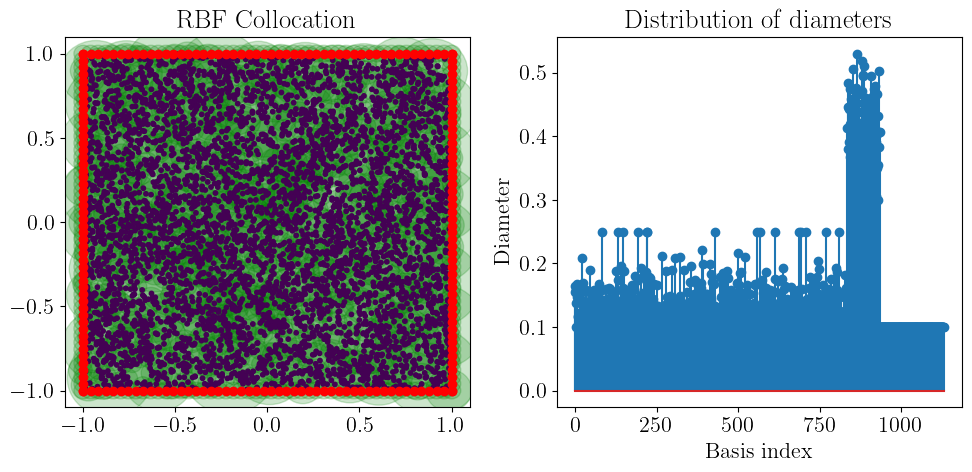

In [8]:
SP.plot_RBFs()

#### Step 4: Assemble the linear system
We assemble the regression, with a penalty for a divergence-free flow

In [9]:
SP.Assembly_Poisson(n_hb=0)

#### Step 5: Solve the linear system
We solve the system, witha fixed condition number of $10^8$ for the matrix $A$. The matrix $M$ is only regularized in this way if the cholesky factorization fails. This is the case here, so we make use of the regularization for $M$ as well with the same conditioning number.

In [10]:
SP.Solve(K_cond=1e12)

Solving with constriaints
Matrix A regularized
Chol factor of M WITH regularization
Lambdas computed
w computed


#### Step 6: Obtain the solution
Here, we use the same grid points as before for an easier comparison, However, this grid can be completely arbitrary!

In [11]:
U_calc = SP.Get_Sol([X,Y])

We can now compute the error in the magnitude of $u$, which is below 1%.

In [13]:
error = np.linalg.norm(U_calc - U) / np.linalg.norm(U)
print('Velocity error in  u: {0:.3f}%'.format(error*100))

Velocity error in  u: 55.418%


Plot the errors.

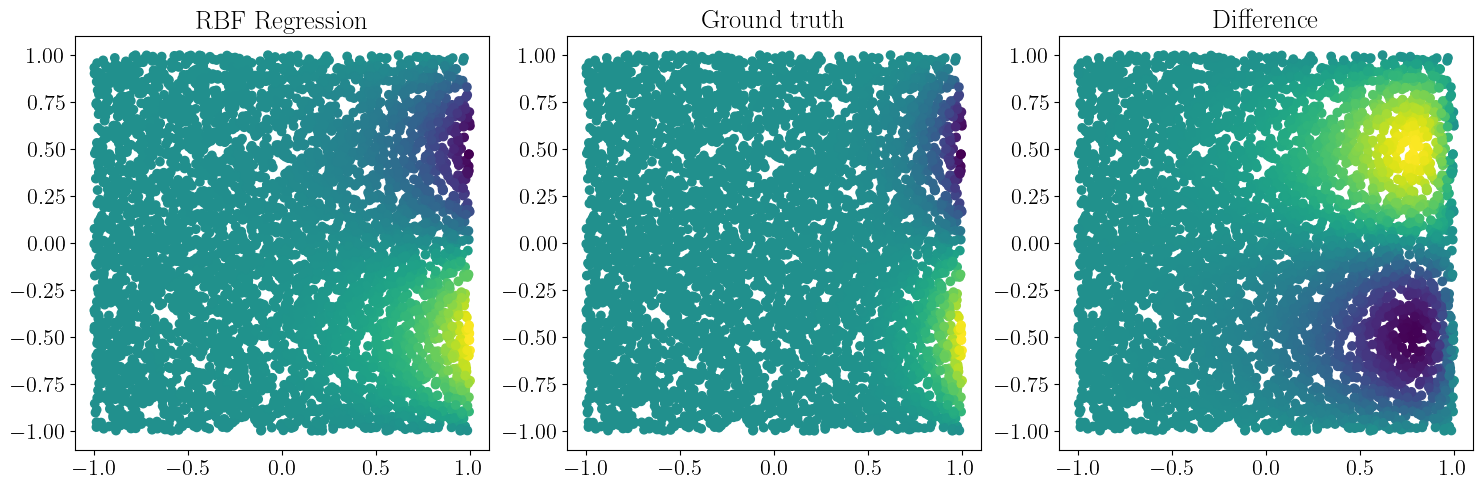

In [17]:
fig, axes = plt.subplots(ncols=3, figsize=(15,5), dpi=100)
axes[0].set_title('RBF Regression')
axes[0].scatter(X, Y, c=U_calc)
axes[1].set_title('Ground truth')
axes[1].scatter(X, Y, c=U)
axes[2].set_title('Difference')
axes[2].scatter(X, Y, c=U-U_calc)
for ax in axes.flatten():
    ax.set_aspect(1)
fig.tight_layout()